# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

https://github.com/petrobras/3W

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA




import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

from sklearn.model_selection import GroupKFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

### Function to calculate metrics

In [2]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

## Read data

In [3]:
df = pd.read_parquet('./data/real_instances.parquet.gzip') 

In [4]:
df.shape

(14516197, 12)

In [5]:
df.head()

,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
timestamp,,,,,,,,,,,,
2017-02-01 02:02:07,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,NaN,0.0,0.0
2017-02-01 02:02:08,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:09,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:10,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:11,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,NaN,0.0,0.0


In [6]:
df.id.nunique()

1013

In [7]:
df['label'].value_counts()

label
0    9903155
4    2462076
3     569152
5     552529
7     466338
1     312136
2     194233
6      56578
Name: count, dtype: int64

In [8]:
df['class'].value_counts()

class
0.0      10003293
4.0       2462076
3.0        569152
105.0      317565
107.0      283262
101.0       95658
102.0       65130
7.0         25870
2.0         16100
5.0         13031
6.0         12951
1.0         10417
106.0        6252
Name: count, dtype: int64

In [9]:
pd.crosstab(df['well'], df['label'])

label,0,1,2,3,4,5,6,7
well,,,,,,,,
WELL-00001,1652442,58468,0,17976,261457,0,0,73033
WELL-00002,3641159,24017,9121,0,807601,0,47869,0
WELL-00003,463543,0,35406,0,0,0,0,0
WELL-00004,85505,0,0,0,307674,0,8709,0
WELL-00005,979611,0,0,0,271525,0,0,0
WELL-00006,2058403,229651,0,0,0,0,0,305517
WELL-00007,14370,0,0,0,71651,0,0,0
WELL-00008,1008122,0,0,0,0,0,0,0
WELL-00009,0,0,6738,0,0,0,0,0


In [10]:
pd.crosstab(df['class'], df['label'])

label,0,1,2,3,4,5,6,7
class,,,,,,,,
0.0,9439612,195376,52017,0,0,127930,36319,152039
1.0,0,10417,0,0,0,0,0,0
2.0,0,0,16100,0,0,0,0,0
3.0,0,0,0,569152,0,0,0,0
4.0,0,0,0,0,2462076,0,0,0
5.0,0,0,0,0,0,13031,0,0
6.0,0,0,0,0,0,0,12951,0
7.0,0,0,0,0,0,0,0,25870
101.0,0,95658,0,0,0,0,0,0


In [11]:
df.drop_duplicates(subset=['id'], keep='last').groupby("label")["id"].count()

label
0    588
1      5
2     22
3     32
4    344
5     11
6      6
7      5
Name: id, dtype: int64

In [12]:
df.isnull().sum()/len(df)

label         0.000000
well          0.000000
id            0.000000
P-PDG         0.000580
P-TPT         0.008007
T-TPT         0.008007
P-MON-CKP     0.077959
T-JUS-CKP     0.113279
P-JUS-CKGL    0.071501
T-JUS-CKGL    1.000000
QGL           0.191125
class         0.043775
dtype: float64

## Dataprep

In [13]:
df['target'] = 1
df.loc[(df['label']==0)&(df['class']==0), "target"] = 0

In [14]:
df.target.value_counts()

target
0    9439612
1    5076585
Name: count, dtype: int64

In [15]:
df.target.value_counts(normalize=True)

target
0    0.650281
1    0.349719
Name: proportion, dtype: float64

In [16]:
df2 = df.drop(['T-JUS-CKGL'], axis=1)
df2 = df2.dropna()

In [17]:
del df

In [18]:
df2.shape

(11108977, 12)

In [19]:
df2.target.value_counts(normalize=True)

target
0    0.663057
1    0.336943
Name: proportion, dtype: float64

In [20]:
df3 = df2.reset_index()
df3.head()

,timestamp,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,class,target
0,2017-02-01 02:02:07,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,0.0,0
1,2017-02-01 02:02:08,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,0.0,0
2,2017-02-01 02:02:09,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,0.0,0
3,2017-02-01 02:02:10,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,0.0,0
4,2017-02-01 02:02:11,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,0.0,0


In [21]:
df3['well'].value_counts()

well
WELL-00002    4518972
WELL-00006    2588359
WELL-00001    2062763
WELL-00014     699734
WELL-00010     601704
WELL-00017     382288
WELL-00018      87162
WELL-00007      86021
WELL-00015      54811
WELL-00016      20465
WELL-00009       6698
Name: count, dtype: int64

In [22]:
df3['id'].value_counts()

id
20180617181315    188331
20140314135248    141046
20180620155728    112748
20170731180930     95415
20140319031616     89674
                   ...  
20170917120016      6750
20170313160804      6698
20180404222255      3891
20180426105723      3172
20180426102531      1606
Name: count, Length: 740, dtype: int64

In [23]:
df2.head()

,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,class,target
timestamp,,,,,,,,,,,,
2017-02-01 02:02:07,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,0.0,0
2017-02-01 02:02:08,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,0.0,0
2017-02-01 02:02:09,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,0.0,0
2017-02-01 02:02:10,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,0.0,0
2017-02-01 02:02:11,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,0.0,0


In [24]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']
VARS_AUX = ['timestamp', 'well', 'target']
data = df3[VARS+VARS_AUX]

In [25]:
data.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp,well,target
0,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,2017-02-01 02:02:07,WELL-00001,0
1,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,2017-02-01 02:02:08,WELL-00001,0
2,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,2017-02-01 02:02:09,WELL-00001,0
3,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,2017-02-01 02:02:10,WELL-00001,0
4,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,2017-02-01 02:02:11,WELL-00001,0


In [26]:
data.dtypes

P-PDG                float64
P-TPT                float64
T-TPT                float64
P-MON-CKP            float64
T-JUS-CKP            float64
P-JUS-CKGL           float64
QGL                  float64
timestamp     datetime64[ns]
well                  object
target                 int64
dtype: object

In [27]:
data['well'].unique()

array(['WELL-00001', 'WELL-00002', 'WELL-00006', 'WELL-00007',
       'WELL-00009', 'WELL-00010', 'WELL-00014', 'WELL-00015',
       'WELL-00016', 'WELL-00017', 'WELL-00018'], dtype=object)

In [28]:
# Lista para armazenar os dados de treinamento e teste
train = list()
test = list()

data = data.sort_values(by=['well', 'timestamp'])

# Iterar sobre cada poco
for poco_id, poco_data in data.groupby('well'):
    # Calcular o índice para dividir os dados em treinamento e teste
    split_index = int(0.80 * len(poco_data))
    
    # Dividir os dados do poco em treinamento e teste
    poco_train = poco_data.iloc[:split_index]
    poco_test = poco_data.iloc[split_index:]
    
    # Adicionar os dados de treinamento e teste à lista
    train.append(poco_train)
    test.append(poco_test)

# Concatenar os dados de treinamento e teste
train = pd.concat(train)
test = pd.concat(test)

# Verificar o tamanho dos conjuntos de treinamento e teste
print("Tamanho do conjunto de treinamento:", len(train))
print("Tamanho do conjunto de teste:", len(test))


Tamanho do conjunto de treinamento: 8887177
Tamanho do conjunto de teste: 2221800


In [29]:
print(f'Treino Poços: {train.well.unique()}')
print(f'Teste Poços: {test.well.unique()}')
print(f'Tamanho do treino: {len(train)}')
print(f'Tamanho do teste: {len(test)}')

Treino Poços: ['WELL-00001' 'WELL-00002' 'WELL-00006' 'WELL-00007' 'WELL-00009'
 'WELL-00010' 'WELL-00014' 'WELL-00015' 'WELL-00016' 'WELL-00017'
 'WELL-00018']
Teste Poços: ['WELL-00001' 'WELL-00002' 'WELL-00006' 'WELL-00007' 'WELL-00009'
 'WELL-00010' 'WELL-00014' 'WELL-00015' 'WELL-00016' 'WELL-00017'
 'WELL-00018']
Tamanho do treino: 8887177
Tamanho do teste: 2221800


In [30]:
# Verificar a proporção de anomalias
print(f"Proporção de anomalias no conjunto de treino: {train.target.mean():.2%}")
print(f"Proporção de anomalias no conjunto de teste: {test.target.mean():.2%}")

Proporção de anomalias no conjunto de treino: 33.92%
Proporção de anomalias no conjunto de teste: 32.77%


In [31]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp,well,target
7365884,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0,2014-01-24 09:33:03,WELL-00001,1
7365885,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0,2014-01-24 09:33:04,WELL-00001,1
7365886,0.0,18433410.0,116.8718,9397032.0,74.80031,-300917.8,0.0,2014-01-24 09:33:05,WELL-00001,1
7365887,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0,2014-01-24 09:33:06,WELL-00001,1
7365888,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0,2014-01-24 09:33:07,WELL-00001,1


In [32]:
train.tail()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp,well,target
11091539,0.0,8431843.0,109.8008,1452053.0,74.09579,9467507.0,0.0,2019-04-03 10:09:23,WELL-00018,1
11091540,0.0,8431876.0,109.8004,1452842.0,74.09563,9467529.0,0.0,2019-04-03 10:09:24,WELL-00018,1
11091541,0.0,8431910.0,109.8000,1453631.0,74.09549,9467550.0,0.0,2019-04-03 10:09:25,WELL-00018,1
11091542,0.0,8431892.0,109.7996,1454419.0,74.09534,9467570.0,0.0,2019-04-03 10:09:26,WELL-00018,1
11091543,0.0,8431875.0,109.7992,1455208.0,74.09519,9467592.0,0.0,2019-04-03 10:09:27,WELL-00018,1


In [33]:
test.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp,well,target
1239889,-6887865.0,9682304.0,118.4759,1873020.0,84.63268,-140331.8,0.0,2017-08-23 19:43:34,WELL-00001,0
1239890,-6887865.0,9682139.0,118.4759,1881098.0,84.63499,-140331.8,0.0,2017-08-23 19:43:35,WELL-00001,0
1239891,-6887865.0,9681974.0,118.4759,1889175.0,84.63731,-140331.8,0.0,2017-08-23 19:43:36,WELL-00001,0
1239892,-6887865.0,9681809.0,118.4759,1897253.0,84.63963,-140331.8,0.0,2017-08-23 19:43:37,WELL-00001,0
1239893,-6887865.0,9681644.0,118.4759,1905330.0,84.64195,-140331.8,0.0,2017-08-23 19:43:38,WELL-00001,0


In [34]:
test.tail()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp,well,target
11108972,0.0,8489354.0,109.7213,1496222.0,73.38219,9706965.0,0.0,2019-04-03 14:59:56,WELL-00018,1
11108973,0.0,8489349.0,109.7212,1495828.0,73.38310,9706899.0,0.0,2019-04-03 14:59:57,WELL-00018,1
11108974,0.0,8489344.0,109.7210,1495433.0,73.38401,9706834.0,0.0,2019-04-03 14:59:58,WELL-00018,1
11108975,0.0,8489338.0,109.7209,1495039.0,73.38493,9706768.0,0.0,2019-04-03 14:59:59,WELL-00018,1
11108976,0.0,8489333.0,109.7207,1494645.0,73.38583,9706702.0,0.0,2019-04-03 15:00:00,WELL-00018,1


In [35]:
train.to_parquet('./data/train_temp.parquet.gzip',
              compression='gzip')

test.to_parquet('./data/test_temp.parquet.gzip',
              compression='gzip')

In [36]:
del data
del df2

In [37]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']

In [38]:
train[VARS].describe()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
count,8.887177e+06,8.887177e+06,8.887177e+06,8.887177e+06,8.887177e+06,8.887177e+06,8.887177e+06
mean,1.235287e+07,2.813876e+07,1.081664e+02,4.674648e+06,7.623365e+01,1.140796e+08,1.625444e-01
std,1.787440e+07,2.052284e+08,2.159599e+01,3.431340e+06,3.564559e+01,4.279944e+08,4.450774e-01
min,-1.259876e+08,4.728049e+06,7.236000e+00,7.528369e+05,-2.020000e+00,-4.976717e+05,0.000000e+00
25%,0.000000e+00,8.556373e+06,1.164812e+02,1.803939e+06,6.165615e+01,2.321333e+06,0.000000e+00
50%,0.000000e+00,1.420617e+07,1.169635e+02,2.542643e+06,7.284150e+01,2.338973e+06,0.000000e+00
75%,2.414653e+07,1.682950e+07,1.177312e+02,6.175858e+06,7.800410e+01,4.558287e+06,0.000000e+00
max,4.485805e+07,2.941990e+09,1.196061e+02,1.235933e+07,1.730961e+02,2.027865e+09,4.146514e+00


Padronização dos dados

In [39]:
# scale = StandardScaler() 
scale = MinMaxScaler()

X_train = scale.fit_transform(train[VARS])

X_test = scale.transform(test[VARS])

X_train = pd.DataFrame(X_train, columns=VARS)
X_test = pd.DataFrame(X_test, columns=VARS)

In [40]:
with open('./models/scale_temp.pkl', 'wb') as file: 
    pickle.dump(scale, file)

## Modeling

In [3]:
file_scale = "./models/scale_temp.pkl"

scale = joblib.load(file_scale)

In [4]:
train = pd.read_parquet('./data/train_temp.parquet.gzip') 
test = pd.read_parquet('./data/test_temp.parquet.gzip') 

In [5]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp,well,target
7365884,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0,2014-01-24 09:33:03,WELL-00001,1
7365885,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0,2014-01-24 09:33:04,WELL-00001,1
7365886,0.0,18433410.0,116.8718,9397032.0,74.80031,-300917.8,0.0,2014-01-24 09:33:05,WELL-00001,1
7365887,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0,2014-01-24 09:33:06,WELL-00001,1
7365888,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0,2014-01-24 09:33:07,WELL-00001,1


In [6]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']

In [7]:
X_train_p = scale.transform(train[VARS])

X_test_p = scale.transform(test[VARS])

X_train_p = pd.DataFrame(X_train_p, columns=VARS)
X_test_p = pd.DataFrame(X_test_p, columns=VARS)

In [8]:
X_train_p.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
0,0.737435,0.004666,0.975667,0.744772,0.438682,0.000097,0.0
1,0.737435,0.004666,0.975667,0.744772,0.438682,0.000097,0.0
2,0.737435,0.004666,0.975667,0.744772,0.438682,0.000097,0.0
3,0.737435,0.004666,0.975667,0.744772,0.438682,0.000097,0.0
4,0.737435,0.004666,0.975667,0.744772,0.438682,0.000097,0.0


In [115]:
# for i in VARS:
#     train_p[i] = train_p[i].astype(float)

# for i in VARS:
#     test_p[i] = test_p[i].astype(float)

### Isolation Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [9]:
iforest=IsolationForest(n_estimators=256, max_samples='auto',max_features=1.0, contamination = 0.33, random_state=74)
inicio = time.time()
iforest.fit(X_train_p)
fim = time.time()
print("time train")
print((fim - inicio)/60)

time train
1.8326517581939696


In [117]:
# 2m57.2s

In [10]:
train['scores_forest']=iforest.decision_function(X_train_p[VARS])
predictions =iforest.predict(X_train_p[VARS])
binary_predictions = np.where(predictions == -1, 1, 0)
train['iForest'] = binary_predictions

In [11]:
test['scores_forest']=iforest.decision_function(X_test_p[VARS])
predictions =iforest.predict(X_test_p[VARS])
binary_predictions = np.where(predictions == -1, 1, 0)
test['iForest'] = binary_predictions

In [12]:
test['iForest'].value_counts()

iForest
1    1317984
0     903816
Name: count, dtype: int64

<Axes: xlabel='scores_forest', ylabel='Density'>

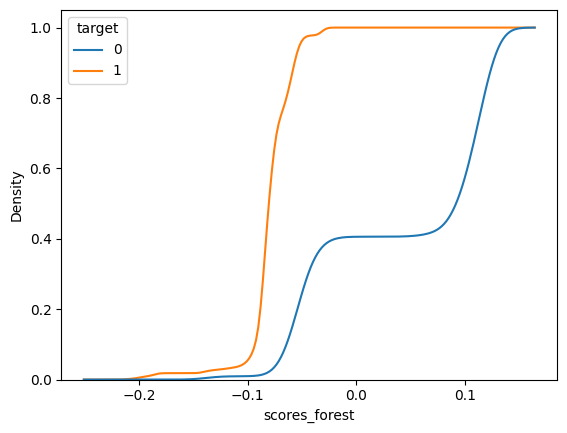

In [13]:
sns.kdeplot(
    data=test.sample(frac=0.01), x="scores_forest", hue=test.target,
    cumulative=True, common_norm=False, common_grid=True,
)

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.60512   0.75399   1493608
           1    0.55250   1.00000   0.71176    728192

    accuracy                        0.73454   2221800
   macro avg    0.77625   0.80256   0.73287   2221800
weighted avg    0.85333   0.73454   0.74015   2221800

Specificity: 0.605122629230695
Gini:  0.605122629230695
ROC AUC::  0.8025613146153475


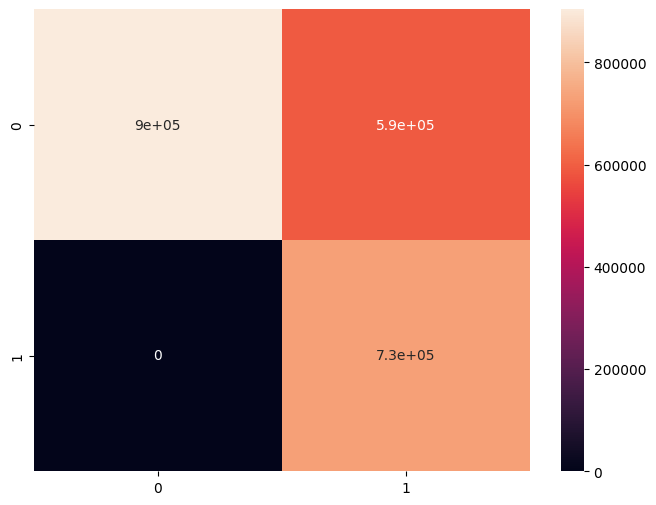

In [14]:
metrics(test.target, test.iForest)

Classification Report: 
               precision    recall  f1-score   support

           0    0.85341   0.86535   0.85934   5872276
           1    0.73039   0.71049   0.72030   3014901

    accuracy                        0.81281   8887177
   macro avg    0.79190   0.78792   0.78982   8887177
weighted avg    0.81168   0.81281   0.81217   8887177

Specificity: 0.8653489720169828
Gini:  0.5758399632634617
ROC AUC::  0.7879199816317308


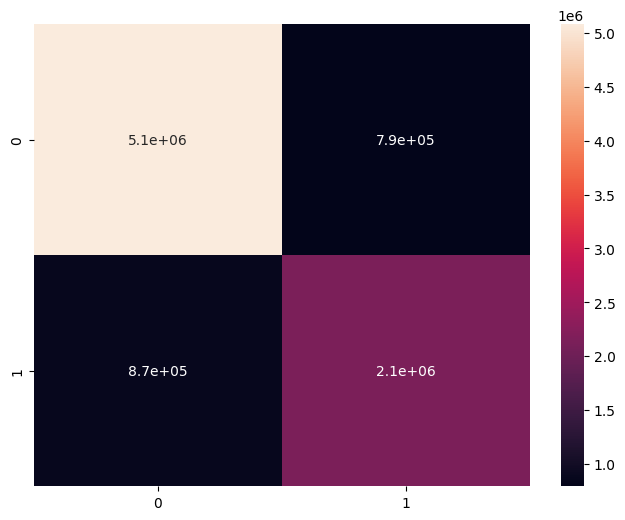

In [15]:
metrics(train.target, train.iForest)

In [16]:
with open('./models/iForest_temp.pkl', 'wb') as file: 
    pickle.dump(iforest, file)

## Algorithms Pyod

https://pyod.readthedocs.io/en/latest/

#### PCA

In [43]:
clf_PCA = PCA(n_components=None, n_selected_components=None, contamination=0.33, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None, weighted=True, standardization=True)
inicio = time.time()
clf_PCA.fit(X_train_p[VARS])
fim = time.time()
print("time train")
print((fim - inicio)/60)

time train
0.08144925038019817


In [44]:
test['score_PCA']= clf_PCA.decision_function(X_test_p[VARS])

In [45]:
test['PCA']=clf_PCA.predict(X_test_p[VARS])

In [46]:
train['PCA']=clf_PCA.predict(X_train_p[VARS])

In [47]:
test['PCA'].value_counts()

PCA
0    1411311
1     810489
Name: count, dtype: int64

Classification Report: 
               precision    recall  f1-score   support

           0    0.93271   0.88132   0.90629   1493608
           1    0.78129   0.86959   0.82308    728192

    accuracy                        0.87748   2221800
   macro avg    0.85700   0.87546   0.86468   2221800
weighted avg    0.88309   0.87748   0.87902   2221800

Specificity: 0.8813209356136282
Gini:  0.750911647953231
ROC AUC::  0.8754558239766155


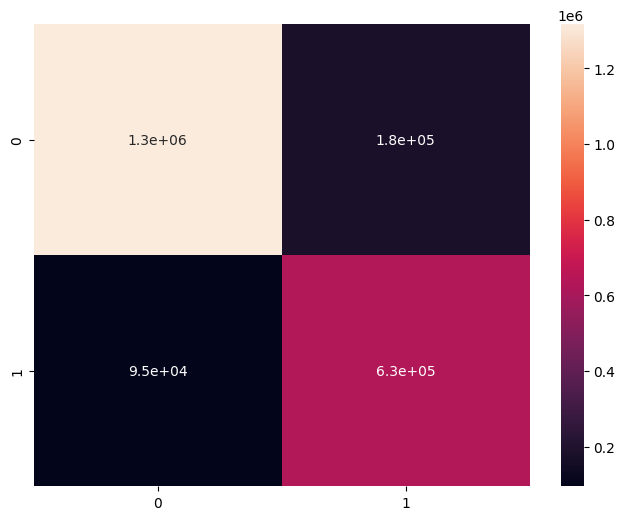

In [48]:
metrics(test.target, test.PCA)

Classification Report: 
               precision    recall  f1-score   support

           0    0.80877   0.82008   0.81439   5872276
           1    0.63976   0.62233   0.63092   3014901

    accuracy                        0.75300   8887177
   macro avg    0.72426   0.72121   0.72266   8887177
weighted avg    0.75144   0.75300   0.75215   8887177

Specificity: 0.8200849210765979
Gini:  0.44241315009638993
ROC AUC::  0.721206575048195


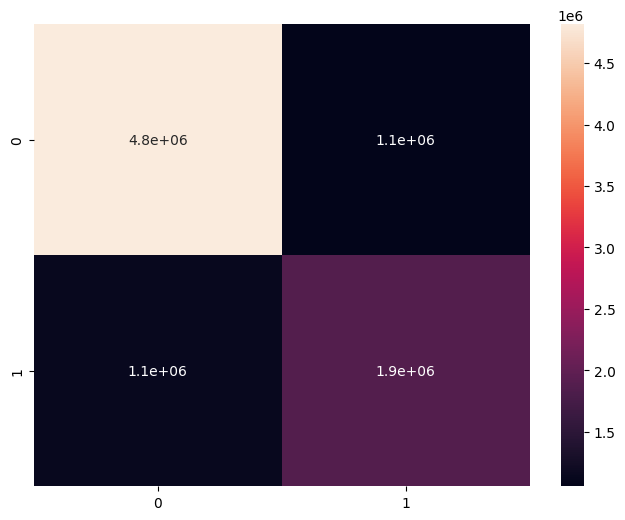

In [49]:
metrics(train.target, train.PCA)

In [50]:
with open('./models/PCA_temp.pkl', 'wb') as file: 
    pickle.dump(clf_PCA, file)

#### LODA

In [51]:
clf_LODA = LODA(contamination=0.33, n_bins=2000, n_random_cuts=1000)
inicio = time.time()
clf_LODA.fit(X_train_p[VARS])
fim = time.time()
print("time train")
print((fim - inicio)/60)

time train
13.325015290578206


In [52]:
# y_train_scores_loda = clf_LODA.decision_scores_  # Outlier scores for training data
test['score_LODA']= clf_LODA.decision_function(X_test_p[VARS])  # Outlier scores for test data

In [53]:
test['LODA']=clf_LODA.predict(X_test_p[VARS])

In [54]:
train['score_LODA']= clf_LODA.decision_function(X_train_p[VARS])  # Outlier scores for test data

In [55]:
train['LODA']=clf_LODA.predict(X_train_p[VARS])

In [56]:
test['LODA'].value_counts()

LODA
1    1316023
0     905777
Name: count, dtype: int64

Classification Report: 
               precision    recall  f1-score   support

           0    0.90561   0.91827   0.91190   5872276
           1    0.83636   0.81358   0.82481   3014901

    accuracy                        0.88276   8887177
   macro avg    0.87098   0.86593   0.86835   8887177
weighted avg    0.88212   0.88276   0.88235   8887177

Specificity: 0.918274107007232
Gini:  0.7318504068592004
ROC AUC::  0.8659252034296002


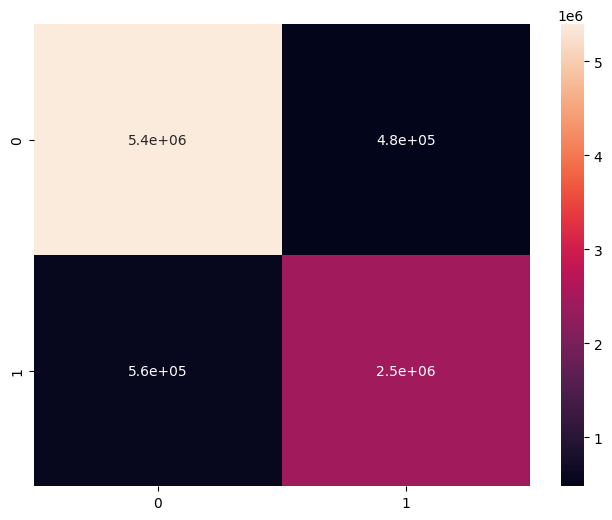

In [57]:
metrics(train.target, train.LODA)

Classification Report: 
               precision    recall  f1-score   support

           0    0.99700   0.60462   0.75274   1493608
           1    0.55126   0.99627   0.70978    728192

    accuracy                        0.73298   2221800
   macro avg    0.77413   0.80044   0.73126   2221800
weighted avg    0.85091   0.73298   0.73866   2221800

Specificity: 0.6046164723274112
Gini:  0.6008853135121537
ROC AUC::  0.8004426567560768


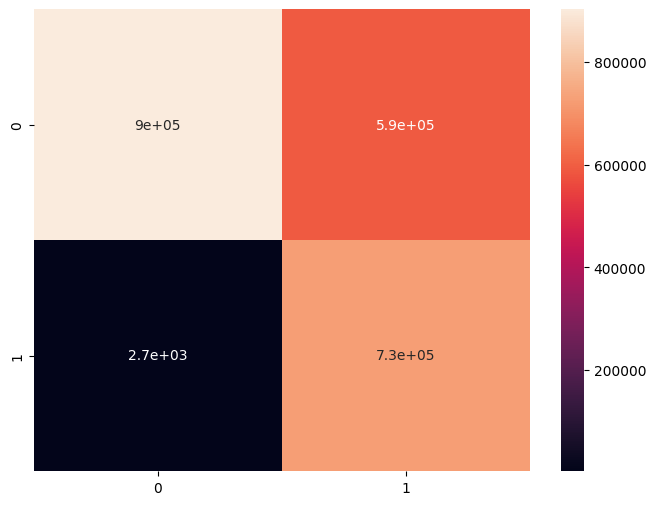

In [58]:
metrics(test.target, test.LODA)

In [59]:
# filename= './models/LODA.sav'
# joblib.dump(clf_LODA, filename)

with open('./models/LODA_temp.pkl', 'wb') as file: 
    pickle.dump(clf_LODA, file)

### SGDOneClassSVM

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDOneClassSVM.html#sklearn.linear_model.SGDOneClassSVM

In [36]:
# OCSVM hyperparameters
nu = 0.33
gamma = None #2.0
random_state = 49

# Fit the One-Class SVM using a kernel approximation and SGD
transform = Nystroem(gamma=gamma, random_state=random_state)
clf_sgd = SGDOneClassSVM(
    nu=nu, shuffle=True, fit_intercept=True, random_state=random_state, tol=1e-4
)

In [37]:
SGDOSVM = make_pipeline(transform, clf_sgd)
inicio = time.time()
SGDOSVM.fit(X_train_p[VARS])
fim = time.time()
print("time train")
print((fim - inicio)/60)

time train
1.3176250378290812


In [38]:
with open('./models/SGDOSVM_temp.pkl', 'wb') as file: 
    pickle.dump(SGDOSVM, file)

In [39]:
test['score_SGDOSVM']=SGDOSVM.decision_function(X_test_p[VARS])
predictions=SGDOSVM.predict(X_test_p[VARS])
binary_predictions = np.where(predictions == -1, 1, 0)
test['SGDOSVM'] = binary_predictions

In [40]:
train['score_SGDOSVM']=SGDOSVM.decision_function(X_train_p[VARS])
predictions =SGDOSVM.predict(X_train_p[VARS])
binary_predictions = np.where(predictions == -1, 1, 0)
train['SGDOSVM'] = binary_predictions


Classification Report: 
               precision    recall  f1-score   support

           0    0.92357   0.68996   0.78985   1493608
           1    0.58130   0.88288   0.70103    728192

    accuracy                        0.75319   2221800
   macro avg    0.75243   0.78642   0.74544   2221800
weighted avg    0.81139   0.75319   0.76074   2221800

Specificity: 0.6899614892260888
Gini:  0.5728399059074036
ROC AUC::  0.7864199529537018


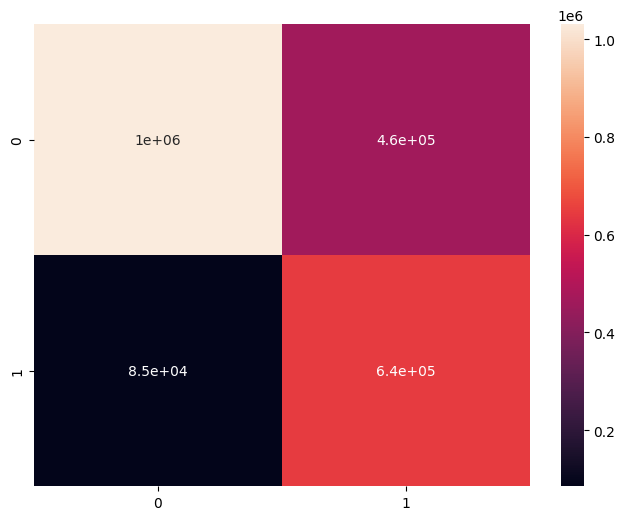

In [41]:
metrics(test.target, test.SGDOSVM)

Classification Report: 
               precision    recall  f1-score   support

           0    0.82831   0.83920   0.83372   5872276
           1    0.67858   0.66120   0.66978   3014901

    accuracy                        0.77882   8887177
   macro avg    0.75345   0.75020   0.75175   8887177
weighted avg    0.77752   0.77882   0.77811   8887177

Specificity: 0.8392027213979725
Gini:  0.5004071854914867
ROC AUC::  0.7502035927457433


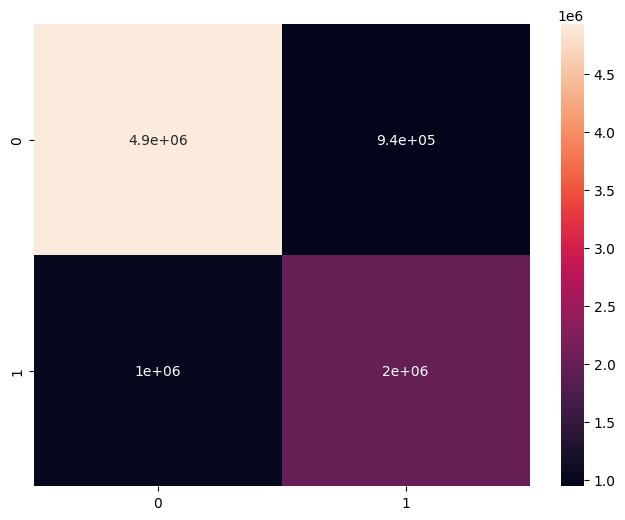

In [42]:
metrics(train.target, train.SGDOSVM)

In [73]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,target,LOF,score_LOF,LODA,SGDOSVM,score_SGDOSVM,PCA,scores_forest,iForest
0,1.0,0.005688,0.972115,0.952631,0.361565,0.000315,0.0,0,0,0.035873,1,1,-0.000335,1,0.006867,0
1,1.0,0.001279,0.977289,0.074749,0.437767,0.001388,0.0,0,1,-0.030771,0,0,0.008457,0,0.112251,0
2,1.0,0.001082,0.973978,0.056972,0.412844,0.001399,0.0,0,1,-0.073850,0,0,0.004351,0,0.075326,0
3,1.0,0.003295,0.975325,0.436429,0.406438,0.001728,0.0,0,1,-0.132518,0,0,0.051933,0,0.084784,0
4,1.0,0.004414,0.982455,0.595038,0.463839,0.000097,0.0,1,0,0.036550,1,0,0.051111,0,-0.020423,1


In [74]:
test.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,target,LOF,score_LOF,score_LODA,LODA,SGDOSVM,score_SGDOSVM,score_PCA,PCA,scores_forest,iForest
0,1.0,0.001006,0.964195,0.085154,0.408313,0.001397,0.0,0,0,0.020408,0.005635,0,0,0.011288,194.756968,0,0.053928,0
1,1.0,0.003185,0.982098,0.417179,0.413305,0.001918,0.0,0,0,0.006406,0.005148,0,0,0.050681,174.807569,0,0.071272,0
2,1.0,0.001155,0.971339,0.047151,0.425904,0.001397,0.0,0,0,0.027792,0.005207,0,0,0.002895,205.106286,0,0.080937,0
3,0.0,0.005696,0.981798,0.945719,0.386956,0.001272,0.0,1,1,-0.012010,0.007272,1,1,-0.181147,789.580006,1,-0.164276,1
4,1.0,0.005684,0.972270,0.951482,0.362717,0.000314,0.0,0,1,-0.008692,0.006875,1,1,-0.000025,327.521482,1,0.018596,0


In [75]:
train.to_parquet('./data/train_score.parquet.gzip',
              compression='gzip')

test.to_parquet('./data/test_score.parquet.gzip',
              compression='gzip')

In [ ]:
# ### Local Outlier Factor
# lof = LocalOutlierFactor(n_neighbors=15, novelty=True, p=2, metric = 'minkowski', contamination=0.33)
# inicio = time.time()
# lof.fit(X_train_p[VARS])
# fim = time.time()
# print("time train")
# print((fim - inicio)/60)
# with open('./models/LOF_temp.pkl', 'wb') as file: 
#     pickle.dump(lof, file)
# test['score_LOF']=lof.decision_function(X_test_p[VARS])
# predictions=lof.predict(X_test_p[VARS])
# binary_predictions = np.where(predictions == -1, 1, 0)
# test['LOF'] = binary_predictions
# train['score_LOF']=lof.decision_function(X_train_p[VARS])
# predictions =lof.predict(X_train_p[VARS])
# binary_predictions = np.where(predictions == -1, 1, 0)
# train['LOF'] =  binary_predictions
# metrics(train.target, train.LOF)
# metrics(test.target, test.LOF)
# filename= './models/LOF.sav'
# joblib.dump(lof, filename)


# with open('./models/LOF.pkl', 'wb') as file: 
#     pickle.dump(lof, file)

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# for poço_id, poço_data in df.groupby('poço_id'):
#     poço_data = poço_data.sort_values(by='date')
#     tscv = TimeSeriesSplit(n_splits=3)
#     for train_index, test_index in tscv.split(poço_data):
#         train, test = poço_data.iloc[train_index], poço_data.iloc[test_index]
        
#         model = IsolationForest(contamination=0.1, random_state=42)
#         model.fit(train[['value']])
        
#         test['anomaly_score'] = model.decision_function(test[['value']])
#         test['anomaly'] = model.predict(test[['value']])
        
#         results.append(test[['date', 'poço_id', 'value', 'anomaly_score', 'anomaly']])


In [ ]:
# # Ordenar os dados por poço e por data para garantir a ordem temporal
# df = data.sort_values(by=['well', 'timestamp'])

# # Configuração do GroupKFold
# gkf = GroupKFold(n_splits=2)


# for train_index, test_index in gkf.split(df, groups=df['well']):
#     train, test = df.iloc[train_index], df.iloc[test_index]
    
#     print(f'Treino Poços: {train.well.unique()}')
#     print(f'Teste Poços: {test.well.unique()}')
#     print(f'Tamanho do treino: {len(train)}')
#     print(f'Tamanho do teste: {len(test)}')



# # Separar dados por poço
# train_pocos, test_pocos = train_test_split(data['well'].unique(), test_size=0.2, random_state=42)

# train = data[data['well'].isin(train_pocos)].sort_values(by=['well', 'timestamp'])
# test = data[data['well'].isin(test_pocos)].sort_values(by=['well', 'timestamp'])

# print(f'Treino Poços: {train_pocos}')
# print(f'Teste Poços: {test_pocos}')
# print(f'Tamanho do treino: {len(train)}')
# print(f'Tamanho do teste: {len(test)}')